# The cosine similarity of posts（BERT）
We perform morphological analysis of the posts using the Juman library, convert each word to a vector (embedding) using BERT, compute the Cos similarity and calculate the average to calculate quantitative similarity.

We used the Japanese model for BERT given by S. Kurohashi and Y. Murawaki, see http://nlp.ist.i.kyoto-u.ac.jp/index.php?BERT日本語Pretrainedモデル.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random as r
from tqdm import tqdm_notebook as tqdm
from pyknp import Juman
import torch
from pytorch_transformers import BertTokenizer, BertModel

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Dir_name = '/Users/goda/Desktop/Dissatisfaction/NLP/Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers'
fname1 = '/Users/goda/Desktop/Dissatisfaction/data/table-posts.csv'
fname2 = '/Users/goda/Desktop/Dissatisfaction/gender/gender_data_12.csv'

data = pd.read_csv(fname1) 
gender_data = pd.read_csv(fname2) 

In [3]:
data["text"][:5]

0    最近の内容は、のび太が、他力本願ですぐ調子にのり、エゴが強すぎると感じている。子供に見せたく...
1                    ヤクルトの舌や喉に何か残る感じの、あれは何でしょう?すごくいやだ。
2                                めばちこ痛い。\n治ってもまたできる...
3    タケダは、からだ浸透補水液は病院の消毒液を連想させる味がします。体に良くても飲み物としてなじ...
4                         チョコリングの個性が弱くて商品として地味で美味しくない。
Name: text, dtype: object

In [4]:
gender_data['text'][:5]

0      特殊な女の付き合いが面倒。\nそれなのに、男も女化している人が増えてきて、相手をするのが面倒。
1    タイミングが遅い!24時間営業だからといってあれはひどい。生鮮品野菜の見切り品コーナーは特に...
2    男女2人で利用したところ、「デートでこんなとこ来るとか」とひそひそ話される声が聞こえて不愉快でした
3    大家のセクハラ発言。二人目はまだか、最近見ないが二人目できたのか、女は嫁に行くから男を産まな...
4    男女平等という言葉を聞きますが、平等は特定の人たちの待遇を優遇するモノだと思いません!\n平...
Name: text, dtype: object

## Morphological Analysis and Tokenization Using Juman

In [5]:
class JumanTokenizer():
    def __init__(self):
        self.juman = Juman()

    def tokenize(self, text):
        result = self.juman.analysis(text)
        tokens = [mrph.midasi for mrph in result.mrph_list()]
        ids = bert_tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens[:126] + ["[SEP]"])
        tokens_tensor = torch.tensor(ids).view(1, -1)
        return tokens_tensor

Tokenizer = JumanTokenizer()

## Loading BERT

In [6]:
model = BertModel.from_pretrained(Dir_name)
bert_tokenizer = BertTokenizer(Dir_name+'/vocab.txt', do_lower_case=False, do_basic_tokenize=False)
model.eval()
None

## Cosine similarity

$a,b$ : embeddings of posts

\begin{align*}
\cos(a,b) = \frac{a \cdot b}{|a||b|}
\end{align*}

In [7]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [8]:
print(len(data["text"]), len(gender_data["text"]))

5248820 24553


Examples

In [9]:
text1 = '東京都の大学で数学の研究をしています。' # I study mathematics at a university in Tokyo.
text2 = '私は東京で統計学の勉強に励んでいる。' # I study statistics in Tokyo.
text3 = '東京都は住むのには良い街です。' # Tokyo is a good city to live in.
text4 = '彼は野球が好きです。' # He likes baseball.
token1 = Tokenizer.tokenize(text1)
token2 = Tokenizer.tokenize(text2)
token3 = Tokenizer.tokenize(text3)
token4 = Tokenizer.tokenize(text4)
with torch.no_grad():
        vector1, _ = model(token1)
        vector2, _ = model(token2)
        vector3, _ = model(token3)
        vector4, _ = model(token4)
sim2 = cos_sim(vector1.mean(axis=1)[0], vector2.mean(axis=1)[0])
sim3 = cos_sim(vector1.mean(axis=1)[0], vector3.mean(axis=1)[0])
sim4 = cos_sim(vector1.mean(axis=1)[0], vector4.mean(axis=1)[0])
print(sim2, sim3, sim4)

0.7685462 0.6020805 0.5652418


In [ ]:
r.seed(0)
M = 10000
cos_list = []
cnt=0
pbar = tqdm(total=M)
while(cnt<M):
    text1, text2 = r.choices(data["text"], k=2)
    try:
        token1 = Tokenizer.tokenize(text1)
        token2 = Tokenizer.tokenize(text2)
    except:
        print("error")
        continue
    token1 = Tokenizer.tokenize(text1)
    token2 = Tokenizer.tokenize(text2)
    with torch.no_grad():
        vector1, _ = model(token1)
        vector2, _ = model(token2)
    sim = cos_sim(vector1.mean(axis=1)[0], vector2.mean(axis=1)[0])
    cos_list.append(sim)
    cnt += 1
    pbar.update(1)
pbar.close()

In [ ]:
r.seed(0)
M = 10000
gender_cos_list = []
cnt=0
pbar = tqdm(total=M)
while(cnt<M):
    text1, text2 = r.choices(gender_data["text"], k=2)
    try:
        token1 = Tokenizer.tokenize(text1)
        token2 = Tokenizer.tokenize(text2)
    except:
        print("error")
        continue
    token1 = Tokenizer.tokenize(text1)
    token2 = Tokenizer.tokenize(text2)
    with torch.no_grad():
        vector1, _ = model(token1)
        vector2, _ = model(token2)
    sim = cos_sim(vector1.mean(axis=1)[0], vector2.mean(axis=1)[0])
    gender_cos_list.append(sim)
    cnt += 1
    pbar.update(1)
pbar.close()

In [ ]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot()
ax.hist(cos_list, alpha=0.5, bins=30, normed=True, label="All Data")
ax.hist(gender_cos_list, alpha=0.5, bins=30, normed=True, label="Gender Data")
ax.legend(fontsize=15)
plt.xlabel('value', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Histogram for BERT', fontsize=20)
plt.savefig("BERT.tiff")

print("Mean of Cos similarity of the overall data :", np.mean(cos_list))
print("Mean of Cos similarity of the gender data :", np.mean(gender_cos_list))

## Similarity of posts between each group.

In [15]:
r.seed(0)
group_cos_list = []
for i in tqdm(range(1,13)):
    for j in range(i,13):
        idx_i = gender_data['label']==i
        idx_j = gender_data['label']==j
        M = 100
        cnt=0
        while(cnt<M):
            text_i = r.choices(list(gender_data[idx_i]["text"]))[0]
            text_j = r.choices(list(gender_data[idx_j]["text"]))[0]
            try:
                token_i = Tokenizer.tokenize(text_i)
                token_j = Tokenizer.tokenize(text_j)
            except:
                print("error")
                continue
            with torch.no_grad():
                vector_i, _ = model(token_i)
                vector_j, _ = model(token_j)
            sim = cos_sim(vector_i.mean(axis=1)[0], vector_j.mean(axis=1)[0])
            group_cos_list.append([sim, i, j])
            cnt += 1

Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error
error
error
error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".


error
error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error
error


Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error
error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis

error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


error


Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".
Analysis is done ignoring "\n".


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':


[[0.74881639 0.75235294 0.7439667  0.75198022 0.73485942 0.7343169
  0.72698741 0.72057008 0.72982297 0.72652204 0.7220113  0.71788982]
 [0.75235294 0.74777722 0.75212287 0.76302478 0.76101098 0.74613394
  0.72173528 0.73314344 0.74322728 0.73386976 0.73606764 0.72609866]
 [0.7439667  0.75212287 0.75846976 0.74744166 0.75528071 0.75367511
  0.73909525 0.73724052 0.73472181 0.73804998 0.7340577  0.72610166]
 [0.75198022 0.76302478 0.74744166 0.76193717 0.74755916 0.74970421
  0.72247525 0.74038481 0.73852644 0.73756373 0.73212147 0.71499385]
 [0.73485942 0.76101098 0.75528071 0.74755916 0.75711559 0.74469206
  0.725528   0.72448058 0.75048182 0.75212156 0.75053206 0.72245447]
 [0.7343169  0.74613394 0.75367511 0.74970421 0.74469206 0.7301313
  0.72651468 0.73074348 0.7256725  0.72855554 0.71843638 0.72440432]
 [0.72698741 0.72173528 0.73909525 0.72247525 0.725528   0.72651468
  0.73372847 0.70342558 0.72190735 0.72547791 0.69611963 0.70541614]
 [0.72057008 0.73314344 0.73724052 0.740384

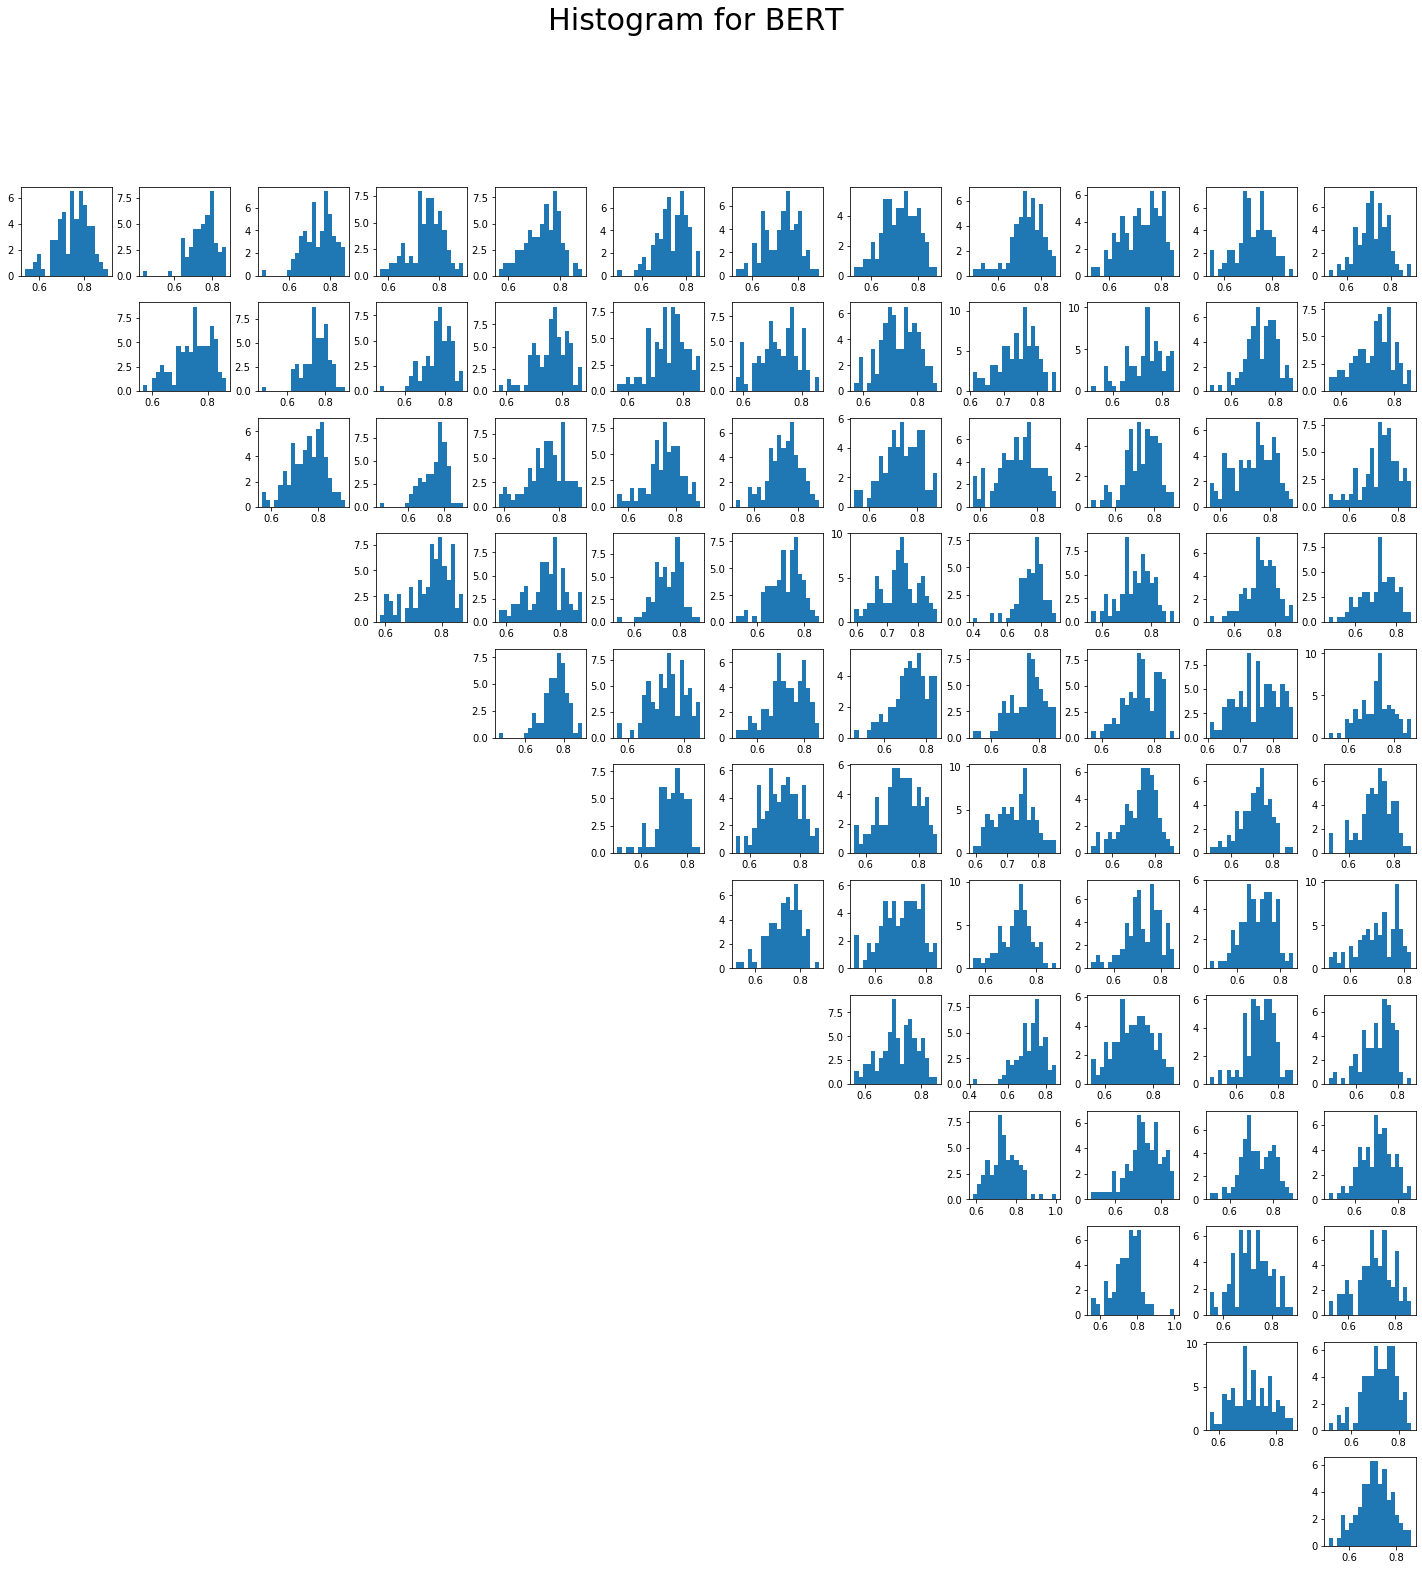

In [16]:
fig = plt.figure(figsize=(25, 25))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
gs = gridspec.GridSpec(12, 12)
g = np.array(group_cos_list)
mat = np.zeros((12,12))

for i in range(12):
    for j in range(i,12):
        ax = fig.add_subplot(gs[i,j])
        plt.subplot(gs[i,j])
        idx = (g.T[1]==(i+1))*(g.T[2]==(j+1))
        ax.hist(g.T[0][idx], bins=20, normed=True)
        mat[i][j] = np.mean(g.T[0][idx])
        mat[j][i] = mat[i][j]

fig.suptitle('Histogram for BERT', fontsize=30)
print(mat)

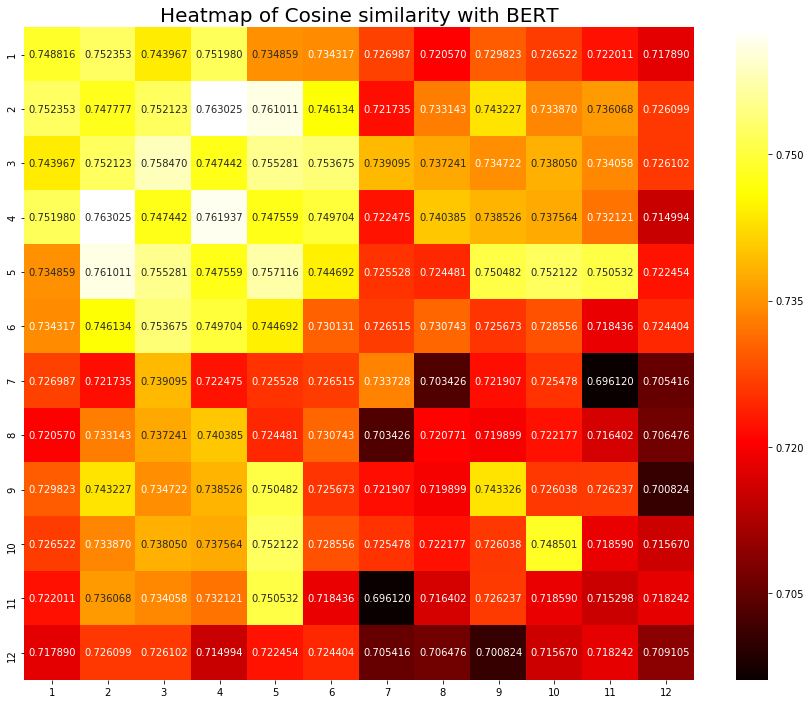

In [17]:
import seaborn as sns
plt.figure(figsize=(15, 12))
sns.heatmap(mat, annot=True, fmt="f", cmap='hot')
plt.xticks(np.array(range(12))+0.5, np.array(range(1,13)))
plt.yticks(np.array(range(12))+0.5, np.array(range(1,13)))
plt.ylim(mat.shape[0],0)
plt.title('Heatmap of Cosine similarity with BERT', fontsize=20)
plt.savefig("heat_BERT.eps")

Text(0.5, 1, 'Heatmap of Estimated Hawkes rate $\\hat{\\rho}$')

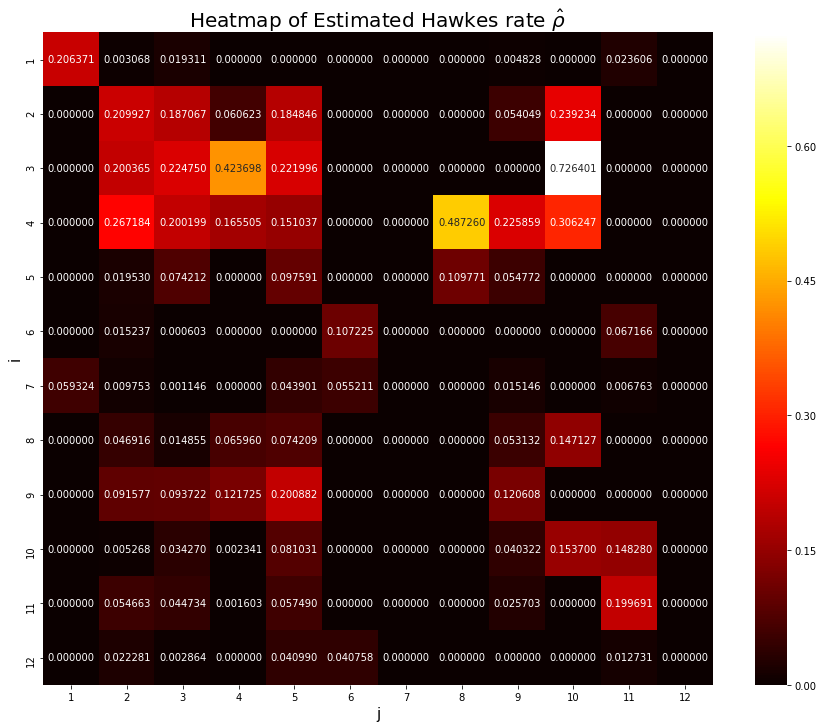

In [18]:
est_pass = '2ndQMLE_res_gender_over400_12.csv' # estimated rho
est = pd.read_csv(est_pass)['0']
dim=12
est_mu = np.array(est[:dim])
est_alpha = np.array(est[dim:(dim+dim**2)]).reshape((dim, dim))
est_beta = np.array(est[(dim+dim**2):]).reshape((dim, dim))
est_rho = est_alpha/est_beta

plt.figure(figsize=(15, 12))
sns.heatmap(est_rho, annot=True, fmt="f", cmap='hot')
plt.xticks(np.array(range(12))+0.5, np.array(range(1,13)))
plt.yticks(np.array(range(12))+0.5, np.array(range(1,13)))
plt.ylim(est_rho.shape[0],0)
plt.xlabel('j', fontsize=15)
plt.ylabel('i', fontsize=15)
plt.title('Heatmap of Estimated Hawkes rate' + r' $\hat{\rho}$', fontsize=20)

## Calculating Spearman's rank correlation coefficient

\begin{align*}
Spearman(X, Y) = 1 - \frac{6\sum_{i=1}^ND^2}{N(N^2-1)}
\end{align*}

$D=$ The difference in rank between the corresponding X and Y values

$N=$ Number of pairs of values

In [21]:
from scipy.stats import spearmanr
spearmanr(mat.flatten(),sym_rho.flatten())

SpearmanrResult(correlation=0.4687916236268972, pvalue=3.1039122510041176e-09)

In [24]:
spearmanr(mat.flatten(),est_rho.flatten())

SpearmanrResult(correlation=0.427768491666327, pvalue=8.903391444249504e-08)